In [1]:
pip install control

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import sympy as sp
import control                   
import control.matlab
import math
import cmath
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import signal

In [47]:
# Declaração de variáveis

#X1 = VC1, X2=VX
A = np.matrix([[0,1],[(-3),(-2)]])
B = np.matrix([[0],[1]])
C = np.matrix([1,0])
D = 0

display(A)
display(B)
display(C)

matrix([[ 0,  1],
        [-3, -2]])

matrix([[0],
        [1]])

matrix([[1, 0]])

Mp= 0.03575060814556352


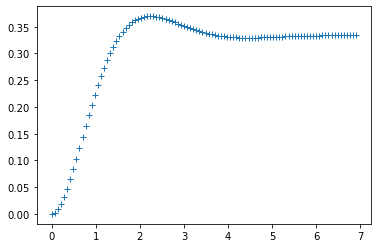

In [48]:
sys= control.ss(A,B,C,D)

ysys, tsys = control.matlab.step(sys)

#print(len(ysys))
#print(ysys[90])
mp = max(ysys)-ysys[len(ysys)-1]
print("Mp=",mp)

# comportamento da saída y                      
plt.figure()
plt.plot(tsys, ysys, '+') #sistema original
plt.show()

In [49]:
# convertendo para função de tranferência com a utilização da função ss2tf 
G = control.ss2tf(sys);
[[n]],[[d]] = control.tfdata(G);
G

TransferFunction(array([1.]), array([1., 2., 3.]))

In [50]:
#GG = np.block([B, A*B, A**2*B]);
#display(GG)
#FF = np.block([C*B,C*A*B, C*A**2*B, D]);
#display(FF)

#print(np.linalg.matrix_rank(GG))
#print(len(A))
#print(np.linalg.matrix_rank(FF))
#print(len(FF))

In [51]:
# Matriz de observabilidade
At=np.conjugate(np.transpose(A))
Ct=np.conjugate(np.transpose(C))
display(At)
display(Ct)

N = np.block([Ct,At*Ct]);
                           
# teste de observabilidade
display(N)
print(np.linalg.matrix_rank(N))
print(len(N))

matrix([[ 0, -3],
        [ 1, -2]])

matrix([[1],
        [0]])

matrix([[1, 0],
        [0, 1]])

2
2


# PROJETO DE CONTROLE DA PLANTA

In [52]:
#PROJETO DE CONTROLE DA PLANTA

#Mp=e^(-pi*Zeta/sqrt(1-Zeta^2))
#zeta=np.sqrt(np.log(Mp)**2/(np.pi**2+np.log(Mp)**2))

zeta = 0.7
wn = 4
Mp = np.exp((-np.pi*zeta)/np.sqrt(1-zeta**2))
ts5=3/(zeta*wn)

#wn=3/(zeta*Ts5)

wd = wn*(1-zeta*zeta)**(1/2)
#ws_wd = 10 
#ws = ws_wd*wd 
#Ts = 2*math.pi/ws
print("tempo de acomodação: ",ts5)
print("sobressinal: ", Mp)
tp = np.pi/wd
print("tempo de pico: ",tp)

tempo de acomodação:  1.0714285714285714
sobressinal:  0.04598791026026775
tempo de pico:  1.0997774062376235


In [53]:
#autovalores desejados do sistema
s1=-zeta*wn + 1j*wd
s2=-zeta*wn - 1j*wd
s3 = 10*np.real(s1)                  # polo não dominante;
print(s1,s2,s3)

(-2.8+2.85657137141714j) (-2.8-2.85657137141714j) -28.0


In [54]:
# Matrizes Expandidas
A_chapeu = np.block([[A, np.zeros([2,1])],[-C, 0]]);
B_chapeu = np.block([[B],[0]]);

In [55]:
# Matriz de Controlabilidade
Mc = np.block([[A, B],[-C, 0]]);
display(Mc)

# teste de controlabilidade  
print("posto: ", np.linalg.matrix_rank(Mc))
print(len(Mc))

matrix([[ 0,  1,  0],
        [-3, -2,  1],
        [-1,  0,  0]])

posto:  3
3


In [56]:
# Matriz de ganhos do controlador K_chapeu = [k1 k2 -ki]
K_chapeu = control.acker(A_chapeu,B_chapeu,[s1, s2, s3])
K_chapeu

matrix([[ 169.8,   31.6, -448. ]])

In [57]:
# Verificando
autovalores, autovetores = linalg.eig(A_chapeu-B_chapeu*K_chapeu);
autovalores

array([-28. +0.j        ,  -2.8+2.85657137j,  -2.8-2.85657137j])

In [58]:
#RESPOSTA AO DEGRAU

K = np.block([K_chapeu[0,0], K_chapeu[0,1]]) #chapeu(1), chapeu(2)
Ki = -K_chapeu[0,2]
AA = np.block([[A-(B*K), B*Ki],[-C,0]])
BB = np.block([[0],[0],[1]])
CC = np.block([1, 0, 0])
DD = 0

#display(A)
display(AA)
display(BB)
display(CC)

matrix([[   0. ,    1. ,    0. ],
        [-172.8,  -33.6,  448. ],
        [  -1. ,    0. ,    0. ]])

array([[0],
       [0],
       [1]])

array([1, 0, 0])

In [59]:
ctr= control.ss(AA,BB,CC,DD) #SISTEMA COMPENSADO

#Fs = 100
#Ts = 1/Fs
tfinal = 7;
#Ts = 0.1 #fs 10 x mais rapido
Kmax = int(tfinal/Ts+1)
t = np.linspace(0, tfinal,Kmax+1);
k = np.linspace(0, Kmax, Kmax+1)
# resposta para entrada ao degrau
Yc, Tc = control.matlab.step(ctr,tfinal)
# separando os elemntos do vetor X 
#x1 = Yc[:,0]; 
#x2 = Yc[:,1]; 
#x1e = Yc[:,2]; 
#x2e = Yc[:,3];

Mp pratico = 0.04545468896926996
Mp teorico = 0.04598791026026775

ts5% pratico = 0.7596899224806202
ts5% teorico = 1.0714285714285714

tp pratico = 1.1296687808315715

tp teorico = 1.0997774062376235


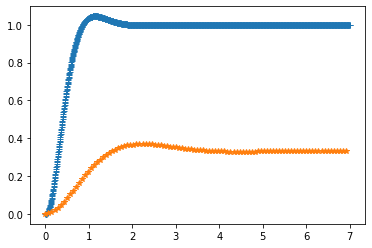

In [60]:
# comportamento da saída y 
mp = max(Yc)-Yc[len(Yc)-1]
print("Mp pratico =",mp)
print("Mp teorico =",Mp)

# Tempo de acomodação para 5%
i = len(Tc) - 1
delta = 0
while delta < 0.05:
    delta = abs(Yc[-1] - Yc[i]) / Yc[-1]
    ts = Tc[i]
    i = i - 1
    
print("\nts5% pratico =",ts)
print("ts5% teorico =",ts5)

# Tempo de pico
j = 0
ind = Yc[0]
while ind < max(Yc):
    tp_pratico = Tc[j]
    j = j+1
    ind = Yc[j+1]
    
print("\ntp pratico =",tp_pratico)
print("\ntp teorico =",tp)

plt.figure()
#plt.plot(Tc, Yc, '+') #sistema original vs compensado
plt.plot(Tc, Yc, '+', tsys, ysys, '*') #sistema original vs compensado
plt.show()

In [61]:
ess = 1 + (CC * AA**-1 * BB)[0,0] 
print("Erro ao degrau: ",ess) 


Erro ao degrau:  0.0
